# Lecture 5: Overfitting
This lecture will take a deeper look at training neural networks. We will specifically focus on the question of what happens when there's a mismatch between our algorithm and dataset.

In [3]:
# import the usual packages
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import mxnet.ndarray as nd
import numpy as np
ctx = mx.cpu()

# for plotting purposes
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

![overfitting](https://tomrobertshaw.net/img/2015/12/overfitting.jpg)
![overfitting2](http://gluon.mxnet.io/_images/regularization-overfitting.png)

The goal of supervised learning is to produce models that generalize to previously unseen data. When a model achieves low error on training data but performs much worse on test data, we say that the model has overfit. This means that the model has caught on to idiosyncratic features of the training data (e.g. one “2” happened to have a white pixel in the top-right corner), but hasn’t really picked up on general patterns.

We can express this more formally. The quantity we really care about is the test error $e$. Because this quantity reflects the error of our model when generalized to previously unseen data, we commonly call it the generalization error. When we have simple models and abundant data, we expect the generalization error to resemble the training error. When we work with more complex models and fewer examples, we expect the training error to go down but the generalization gap to grow. Fixing the size of the dataset, the following graph should give you some intuition about what we generally expect to see.


What precisely constitutes model complexity is a complex matter. Many factors govern whether a model will generalize well. For example a model with more parameters might be considered more complex. A model whose parameters can take a wider range of values might be more complex. Often with neural networks, we think of a model that takes more training steps as more complex, and one subject to early stopping as less complex.

It can be difficult to compare the complexity among members of very different model classes (say decision trees versus neural networks). Researchers in the field of statistical learning theory have developed a large body of mathematical analysis that formulizes the notion of model complexity and provides guarantees on the generalization error for simple classes of models. We won’t get into this theory but may delve deeper in a future chapter. For now a simple rule of thumb is quite useful: A model that can readily explain arbitrary facts is what statisticians view as complex, whereas one that has only a limited expressive power but still manages to explain the data well is probably closer to the truth. In philosophy this is closely related to Popper’s criterion of falsifiability of a scientific theory: a theory is good if it fits data and if there are specific tests which can be used to disprove it. This is important since all statistical estimation is post hoc, i.e. we estimate after we observe the facts, hence vulnerable to the associated fallacy. Ok, enough of philosophy, let’s get to more tangible issues.

To give you some intuition in this chapter, we’ll focus on a few factors that tend to influence the generalizability of a model class:

1. __The number of tunable parameters__. When the number of tunable parameters, sometimes denoted as the number of degrees of freedom, is large, models tend to be more susceptible to overfitting.
2. __The values taken by the parameters__. When weights can take a wider range of values, models can be more susceptible to over fitting.
3. __The number of training examples__. It’s trivially easy to overfit a dataset containing only one or two examples even if your model is simple. But overfitting a dataset with millions of examples requires an extremely flexible model.


When classifying handwritten digits before, we didn’t overfit because our 60,000 training examples far out numbered the $784×10=7,840$ weights plus $10$ bias terms, which gave us far fewer parameters than training examples. Let’s see how things can go wrong.

In [9]:
# load mnist
mnist = mx.test_utils.get_mnist()
num_examples = 1000
batch_size = 64
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["train_data"][:num_examples],
                               mnist["train_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(mnist["test_data"][:num_examples],
                               mnist["test_label"][:num_examples].astype(np.float32)),
                               batch_size, shuffle=False)

/opt/conda/envs/mxnet-py3.6/lib/python3.6/site-packages/mxnet/test_utils.py:1430: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(flbl.read(), dtype=np.int8)
/opt/conda/envs/mxnet-py3.6/lib/python3.6/site-packages/mxnet/test_utils.py:1433: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)


This looks similar to before, except that we are only loading 1000 samples, this means our network has much less data to work with, and is consequently more prone to overfitting.

Lets define a simple perceptron like network and see how training goes.

In [19]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(10))
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
loss = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.0})

In [20]:
def evaluate_accuracy(data_iterator, net, loss_fun):
    acc = mx.metric.Accuracy()
    loss_avg = 0.
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1,784))
        label = label.as_in_context(ctx)
        with autograd.predict_mode():
            output = net(data)
            loss = loss_fun(output, label)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
        loss_avg = loss_avg*i/(i+1) + nd.mean(loss).asscalar()/(i+1)
    return acc.get()[1], loss_avg

def plot_learningcurves(loss_tr,loss_ts, acc_tr,acc_ts):
    xs = list(range(len(loss_tr)))

    f = plt.figure(figsize=(12,6))
    fg1 = f.add_subplot(121)
    fg2 = f.add_subplot(122)

    fg1.set_xlabel('epoch',fontsize=14)
    fg1.set_title('Comparing loss functions')
    fg1.semilogy(xs, loss_tr)
    fg1.semilogy(xs, loss_ts)
    fg1.grid(True,which="both")

    fg1.legend(['training loss', 'testing loss'],fontsize=14)

    fg2.set_title('Comparing accuracy')
    fg1.set_xlabel('epoch',fontsize=14)
    fg2.plot(xs, acc_tr)
    fg2.plot(xs, acc_ts)
    fg2.grid(True,which="both")
    fg2.legend(['training accuracy', 'testing accuracy'],fontsize=14)

Completed epoch 1. Train Loss: 2.2295248806476593, Test Loss 2.20820865035057, Train_acc 0.181, Test_acc 0.211
Completed epoch 101. Train Loss: 0.7123892419040203, Test Loss 0.9256445206701756, Train_acc 0.88, Test_acc 0.786
Completed epoch 201. Train Loss: 0.7001075185835361, Test Loss 0.9142203070223331, Train_acc 0.884, Test_acc 0.791
Completed epoch 301. Train Loss: 0.7005291618406774, Test Loss 0.9132727384567261, Train_acc 0.885, Test_acc 0.792
Completed epoch 401. Train Loss: 0.6972614340484142, Test Loss 0.913304928690195, Train_acc 0.885, Test_acc 0.789
Completed epoch 501. Train Loss: 0.6981222741305827, Test Loss 0.9135230518877507, Train_acc 0.886, Test_acc 0.793
Completed epoch 601. Train Loss: 0.6959958821535108, Test Loss 0.9135025143623353, Train_acc 0.885, Test_acc 0.791
Completed epoch 701. Train Loss: 0.6965774595737457, Test Loss 0.9127378650009632, Train_acc 0.883, Test_acc 0.792
Completed epoch 801. Train Loss: 0.7021924406290054, Test Loss 0.9135776311159134, Tra

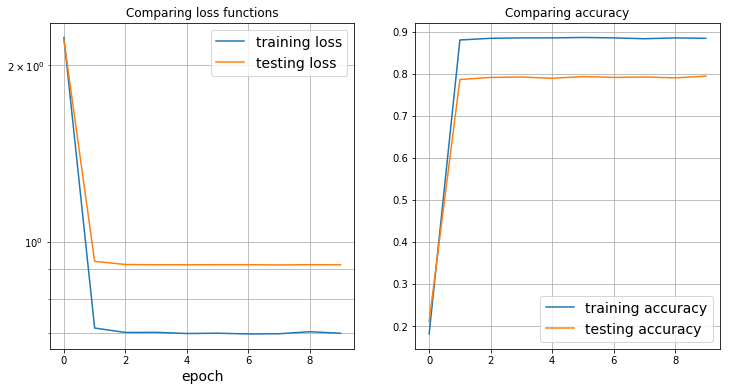

In [26]:
def train(net, trainer):
    epochs = 1000
    moving_loss = 0.
    niter=0

    loss_seq_train = []
    loss_seq_test = []
    acc_seq_train = []
    acc_seq_test = []

    for e in range(epochs):
        for i, (data, label) in enumerate(train_data):
            data = data.as_in_context(ctx).reshape((-1,784))
            label = label.as_in_context(ctx)
            with autograd.record():
                with autograd.train_mode():
                    output = net(data)
                    cross_entropy = loss(output, label)
            cross_entropy.backward()
            trainer.step(data.shape[0])

            ##########################
            #  Keep a moving average of the losses
            ##########################
            niter +=1
            moving_loss = .99 * moving_loss + .01 * nd.mean(cross_entropy).asscalar()
            est_loss = moving_loss/(1-0.99**niter)

        if e % 100 == 0:
            test_accuracy, test_loss = evaluate_accuracy(test_data, net, loss)
            train_accuracy, train_loss = evaluate_accuracy(train_data, net, loss)

            # save them for later
            loss_seq_train.append(train_loss)
            loss_seq_test.append(test_loss)
            acc_seq_train.append(train_accuracy)
            acc_seq_test.append(test_accuracy)
            print("Completed epoch %s. Train Loss: %s, Test Loss %s, Train_acc %s, Test_acc %s" %
                  (e+1, train_loss, test_loss, train_accuracy, test_accuracy))

    ## Plotting the learning curves
    plot_learningcurves(loss_seq_train,loss_seq_test,acc_seq_train,acc_seq_test)
    
train(net, trainer)    

We can very clearly see the symptoms of overfitting, but what actions can we take to improve our accuracy? In this, we can't reduce our model complexity, since it's already a single neuron. Instead, we can try limiting the value the weights can take. If the weights cant go off and draw goofy lines, they might be forced to take more __general__ values.

We can apply this restriction by adding a term to the loss.

$\text{weight_penalty} = \lambda \sum \boldsymbol{w}^2$

Where $\lambda$ is the strength of the penalty we want to apply. The larger $\lambda$ is, the more the weights will go towards zero. Then the total loss becomes

loss $= \sum (\hat{y} - y)^2 + \lambda \sum \boldsymbol{w}^2$

We see now that the network has two objectives, classify the image correctly, and keep its weights low.

Although we could implement this regularization by manually computing the sum of $w$ and adding to the loss in the training loop, there's already a convenient option in the SGD trainer!

Completed epoch 1. Train Loss: 2.2283490896224976, Test Loss 2.189020454883576, Train_acc 0.19, Test_acc 0.247
Completed epoch 101. Train Loss: 0.47829840891063213, Test Loss 0.6890839897096159, Train_acc 0.895, Test_acc 0.809
Completed epoch 201. Train Loss: 0.37342066690325737, Test Loss 0.6036215182393789, Train_acc 0.923, Test_acc 0.829
Completed epoch 301. Train Loss: 0.3350711446255445, Test Loss 0.5746157262474298, Train_acc 0.933, Test_acc 0.834
Completed epoch 401. Train Loss: 0.30768139660358423, Test Loss 0.5604869369417427, Train_acc 0.944, Test_acc 0.833
Completed epoch 501. Train Loss: 0.2931176843121648, Test Loss 0.5536692179739475, Train_acc 0.948, Test_acc 0.839
Completed epoch 601. Train Loss: 0.2868707459419965, Test Loss 0.550052462145686, Train_acc 0.954, Test_acc 0.839
Completed epoch 701. Train Loss: 0.2788556655868887, Test Loss 0.5475284419953823, Train_acc 0.958, Test_acc 0.84
Completed epoch 801. Train Loss: 0.2705175559967756, Test Loss 0.5460386462509632, 

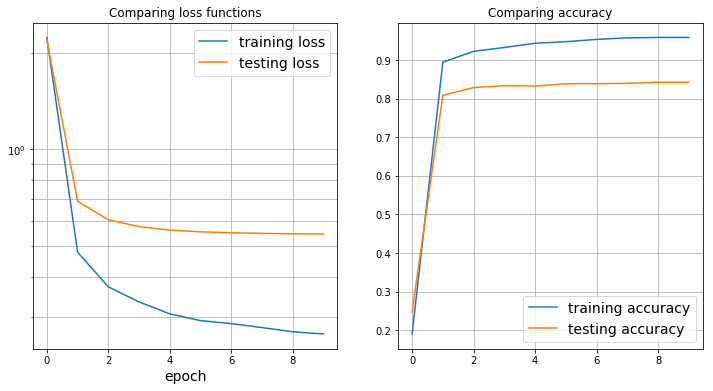

In [29]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.01})
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), force_reinit=True, ctx=ctx)
train(net, trainer)

Adding our weight regularization (wd) term boosted our accuracy quite a bit! This regularization method is known as $L_2$ regularization, because we were trying to minimize the square of weights.

Other ways we could reduce the overfitting include:
1. We could require the sum of weights be small, similar to what we did but using a penaly $\sum |\boldsymbol{w}|$. This is called $L_1$ regularization
2. We could require the largest weight be not too large, using a penalty on $\text{max}(|\boldsymbol{w}|)$. This is called $L_\infty$ regularization
3. We could require that most weights be zero, using a penalty of $\sum I\{\boldsymbol{w} \neq 0\}$. This is called $L_0$ regularization.

## Dropout: Reducing overfitting with noise

![dropout](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_5/dropout.jpeg)

In [35]:
# first lets make a multi layer neural network and see how we do with training
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(256, activation='relu'))
    net.add(gluon.nn.Dense(256, activation='relu'))
    net.add(gluon.nn.Dense(10))
    
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)  
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.0})

Completed epoch 1. Train Loss: 2.2444174885749817, Test Loss 2.2733509391546254, Train_acc 0.152, Test_acc 0.116
Completed epoch 101. Train Loss: 0.20494750328361988, Test Loss 0.49024988524615765, Train_acc 0.957, Test_acc 0.842
Completed epoch 201. Train Loss: 0.07627503830008209, Test Loss 0.46976645570248354, Train_acc 0.994, Test_acc 0.852
Completed epoch 301. Train Loss: 0.035017508780583746, Test Loss 0.49097774270921946, Train_acc 1.0, Test_acc 0.846
Completed epoch 401. Train Loss: 0.019737667345907532, Test Loss 0.5126768536865711, Train_acc 1.0, Test_acc 0.849
Completed epoch 501. Train Loss: 0.012951102282386277, Test Loss 0.5331845739856362, Train_acc 1.0, Test_acc 0.852
Completed epoch 601. Train Loss: 0.009488290088484064, Test Loss 0.5503736417740582, Train_acc 1.0, Test_acc 0.853
Completed epoch 701. Train Loss: 0.007266614004038274, Test Loss 0.5653062406927348, Train_acc 1.0, Test_acc 0.853
Completed epoch 801. Train Loss: 0.005814714910229667, Test Loss 0.5787375094

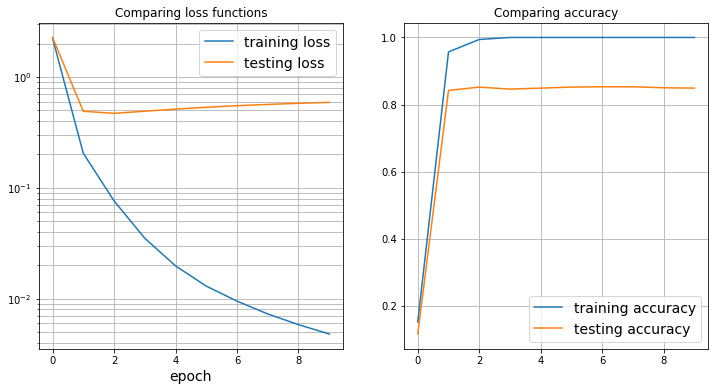

In [36]:
train(net, trainer)

We can see this network very quickly overfit, that's not surprising because it has so many parameters! Let's try adding dropout layers and see what happens.

In [58]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(256, activation='relu'))
    net.add(gluon.nn.Dropout(.5))
    net.add(gluon.nn.Dense(256, activation='relu'))
    net.add(gluon.nn.Dropout(.5))
    net.add(gluon.nn.Dense(10))
    
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)  
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01, 'wd': 0.0})

In [59]:
for x, _ in train_data:
    x = x.as_in_context(ctx)
    break
print(net(x[0:1]))
print(net(x[0:1]))


[[ 0.12781018 -0.23351493 -0.1609863   0.4240821  -0.1919708  -0.07869464
   0.24162754 -0.09909573 -0.04394392 -0.05956013]]
<NDArray 1x10 @cpu(0)>

[[ 0.12781018 -0.23351493 -0.1609863   0.4240821  -0.1919708  -0.07869464
   0.24162754 -0.09909573 -0.04394392 -0.05956013]]
<NDArray 1x10 @cpu(0)>


Dropout layers only turn on when the network is training. It'd be silly to add noise during testing since we want as high of accuracy as possible then! By default MXNet assumes we are doing a prediction as opposed to training. That's why the two outputs above are the same. The above cell is equivalent to saying

In [60]:
with autograd.predict_mode():
    print(net(x[0:1]))
    print(net(x[0:1]))


[[ 0.12781018 -0.23351493 -0.1609863   0.4240821  -0.1919708  -0.07869464
   0.24162754 -0.09909573 -0.04394392 -0.05956013]]
<NDArray 1x10 @cpu(0)>

[[ 0.12781018 -0.23351493 -0.1609863   0.4240821  -0.1919708  -0.07869464
   0.24162754 -0.09909573 -0.04394392 -0.05956013]]
<NDArray 1x10 @cpu(0)>


To turn on dropout, we have to activate training mode

In [61]:
with autograd.train_mode():
    print(net(x[0:1]))
    print(net(x[0:1]))


[[-0.2942212  -0.42762232  0.75384384  0.7338412   2.3694186   0.2261978
   2.423419   -1.9527712   1.1812178   1.1856863 ]]
<NDArray 1x10 @cpu(0)>

[[-2.4718394  -2.1026561  -0.8300202  -1.9103373  -2.2880208   1.0584509
   0.9919447   0.16191907  1.1276935   0.45780447]]
<NDArray 1x10 @cpu(0)>


We see that with training mode activated, there is some random activity in our network! A different way of thinking about dropout is that the network cant rely on all its neurons for any one task, it needs to create a more general ensemble from many neurons to get reliable answers. Let's see if that translates to training.

Completed epoch 1. Train Loss: 2.2972182482481003, Test Loss 2.298377811908722, Train_acc 0.119, Test_acc 0.117
Completed epoch 101. Train Loss: 1.7489264011383057, Test Loss 1.8517178669571877, Train_acc 0.67, Test_acc 0.58
Completed epoch 201. Train Loss: 1.2708139047026636, Test Loss 1.4534039795398712, Train_acc 0.795, Test_acc 0.679
Completed epoch 301. Train Loss: 0.9722089804708958, Test Loss 1.1919911056756975, Train_acc 0.843, Test_acc 0.72
Completed epoch 401. Train Loss: 0.7716210149228572, Test Loss 1.0264470987021923, Train_acc 0.864, Test_acc 0.74
Completed epoch 501. Train Loss: 0.638260368257761, Test Loss 0.9285305291414262, Train_acc 0.876, Test_acc 0.75
Completed epoch 601. Train Loss: 0.5615790709853172, Test Loss 0.8805262818932533, Train_acc 0.888, Test_acc 0.751
Completed epoch 701. Train Loss: 0.4937348533421754, Test Loss 0.8548522628843785, Train_acc 0.898, Test_acc 0.762
Completed epoch 801. Train Loss: 0.44389040581882, Test Loss 0.8537236340343952, Train_ac

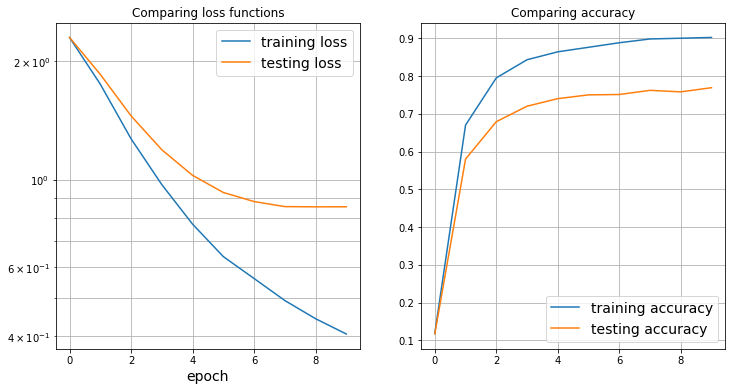

In [62]:
train(net, trainer)

If everything worked, we should see our test accuracy increased by a few percent. For such a small adjustment thats great! For most of the projects in this course, the datasets being trained on will be small. This means that overfitting will be a big threat!

Interesting side node: There are other ways to add noise! Sometimes it's useful to simply add some randomness to the training data. For example, in computer vision, it is common practice to distort incoming images. This helps a lot with generalization!

![distortion](http://wiki.fast.ai/images/c/c5/Data_aug.png)